## 1. Comparison of CNN based image classification architectures
In this tutorial I am going to compare the most popular CNN based DNN architectures for Image Classification, including ***LeNet-5, AlexNet, VGGNet, GoogleNet, ResNet, DenseNet, MobileNet, EfficientNet, Xception and Ensemble method which is DEX (DenseNet, EfficientNet, and Xception).***

And I am gonna use CIFAR-100 dataset to compare all architectures given above. CIFAR-100 contains 60000 32x32 images accross 100 classes.

> **Note:** I trained LeNet-5 CNN architecture on CIFAR-10 dataset with and without data agumentation. Despite getting lower accuracy on training dataset with agumentation, but I got 2% more (70.11 % accuracy) accuracy on the test dataset when I trained the model with data agumentation. That means after image agumentation my LeNet-5 image classification model is able to generalize well on new unseen dataset.




## 1. LNet-5

### 1.1 Imports

In [ ]:
import os
import time

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

import matplotlib.pyplot as plt
from PIL import Image

if torch.cuda.is_available():
  torch.backends.cudnn.deterministic = True


### 1.2 Model Settings

In [ ]:
### SETTINGS ###

# Hyperparameters
RANDOM_SEED = 1
LEARNING_RATE = 0.001
BATCH_SIZE = 128
NUM_EPOCHS = 10

# Architecture
NUM_FEATURES = 32*32
NUM_CLASSES = 10

# Other
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
GRAYSCALE = False

### 1.3 CIFAR-10 Dataset




In [ ]:
### CIFAR-10 Dataset ###

train_dataset = datasets.CIFAR10(root='data',
                                 train=True,
                                 transform=transforms.ToTensor(),
                                 download=True)
test_dataset = datasets.CIFAR10(root='data',
                                train=False,
                                transform=transforms.ToTensor())

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=8,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                         batch_size=BATCH_SIZE,
                         num_workers=8,
                         shuffle=False)

# Checking the dataset

for images, labels in train_loader:
  print(f"Image batch demensions: {images.shape}")
  print(f"Image label demensions: {labels.shape}")
  break

for images, labels in test_loader:
  print(f"Image batch demensions: {images.shape}")
  print(f"Image label demensions: {labels.shape}")
  break

100%|██████████| 170M/170M [00:03<00:00, 42.8MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Image batch demensions: torch.Size([128, 3, 32, 32])
Image label demensions: torch.Size([128])
Image batch demensions: torch.Size([128, 3, 32, 32])
Image label demensions: torch.Size([128])


In [ ]:
device = torch.device(DEVICE)

torch.manual_seed(0)

for epoch in range(2):
  for batch_idx, (x, y) in enumerate(train_loader):
    print('Epoch:', epoch+1, end='')
    print(' | Batch index:', batch_idx, end='')
    print(' | Batch size:', y.size()[0])

    x = x.to(device)
    y = y.to(device)
    break

Epoch: 1 | Batch index: 0 | Batch size: 128
Epoch: 2 | Batch index: 0 | Batch size: 128


In [ ]:
### MODEL ###

class LeNet5(nn.Module):
  def __init__(self, num_classes, grayscale=False):
    super(LeNet5, self).__init__()

    self.grayscale = grayscale
    self.num_classes = num_classes

    if self.grayscale:
      in_channels = 1
    else:
      in_channels = 3

    self.features = nn.Sequential(
        nn.Conv2d(in_channels, 6*in_channels, kernel_size=5),
        nn.Tanh(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(6*in_channels, 16*in_channels, kernel_size=5),
        nn.Tanh(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.classifier = nn.Sequential(
        nn.Linear(16*5*5*in_channels, 120*in_channels),
        nn.Tanh(),
        nn.Linear(120*in_channels, 84*in_channels),
        nn.Tanh(),
        nn.Linear(84*in_channels, num_classes),
    )
  def forward(self, x):
    x = self.features(x)
    x = torch.flatten(x, 1)
    logits = self.classifier(x)
    probas = F.softmax(logits, dim=1)
    return logits, probas

In [ ]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(NUM_CLASSES, GRAYSCALE)
model.to(DEVICE)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

### 1.4 Trainig

In [ ]:
## Install tqdm to use progress bar
!pip install tqdm
import tqdm
import time

In [ ]:
train_losses = []
train_accuracies = []
def compute_accuracy(model, data_loader, device):
  correct_pred, num_examples = 0, 0
  for batch_idx, (features, targets) in enumerate(data_loader):

    features = features.to(device)
    targets = targets.to(device)

    logits, probas = model(features)
    _, predicted_labels = torch.max(probas, 1)
    num_examples += targets.size(0)
    correct_pred += (predicted_labels == targets).sum()

  return correct_pred.float()/num_examples*100

start_time = time.time()
for epoch in range(NUM_EPOCHS):
  model.train()
  running_loss = 0
  correct = 0
  total = 0

  for batch_idx, (features, targets) in enumerate(train_loader):

    features = features.to(DEVICE)
    targets = targets.to(DEVICE)

    ### Forward and Back propagation
    logits, probs = model(features)
    loss = F.cross_entropy(logits, targets)
    optimizer.zero_grad()

    loss.backward()

    ### Update params
    optimizer.step()

    ## Total loss of each epoch
    running_loss += loss.item()

    # Accuracy
    _, predicted = torch.max(probs, 1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

    ### Logging
    if batch_idx % 50 == 0:
      print ('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                  %(epoch+1, NUM_EPOCHS, batch_idx,
                    len(train_loader), loss))
  avg_loss = running_loss/len(train_loader)
  accuracy = correct/total

  train_losses.append(avg_loss)
  train_accuracies.append(accuracy)


Epoch: 001/010 | Batch 0000/0391 | Loss: 2.3115
Epoch: 001/010 | Batch 0050/0391 | Loss: 1.7791
Epoch: 001/010 | Batch 0100/0391 | Loss: 1.5891
Epoch: 001/010 | Batch 0150/0391 | Loss: 1.5905
Epoch: 001/010 | Batch 0200/0391 | Loss: 1.3676
Epoch: 001/010 | Batch 0250/0391 | Loss: 1.4069
Epoch: 001/010 | Batch 0300/0391 | Loss: 1.2807
Epoch: 001/010 | Batch 0350/0391 | Loss: 1.6192
Epoch: 002/010 | Batch 0000/0391 | Loss: 1.1207
Epoch: 002/010 | Batch 0050/0391 | Loss: 1.2294
Epoch: 002/010 | Batch 0100/0391 | Loss: 1.2803
Epoch: 002/010 | Batch 0150/0391 | Loss: 1.1991
Epoch: 002/010 | Batch 0200/0391 | Loss: 1.2359
Epoch: 002/010 | Batch 0250/0391 | Loss: 1.2496
Epoch: 002/010 | Batch 0300/0391 | Loss: 1.0751
Epoch: 002/010 | Batch 0350/0391 | Loss: 1.1897
Epoch: 003/010 | Batch 0000/0391 | Loss: 1.2001
Epoch: 003/010 | Batch 0050/0391 | Loss: 1.0510
Epoch: 003/010 | Batch 0100/0391 | Loss: 1.2050
Epoch: 003/010 | Batch 0150/0391 | Loss: 1.0391
Epoch: 003/010 | Batch 0200/0391 | Loss:

#### 1.4.1 Plotting Loss Curve and Accuracy

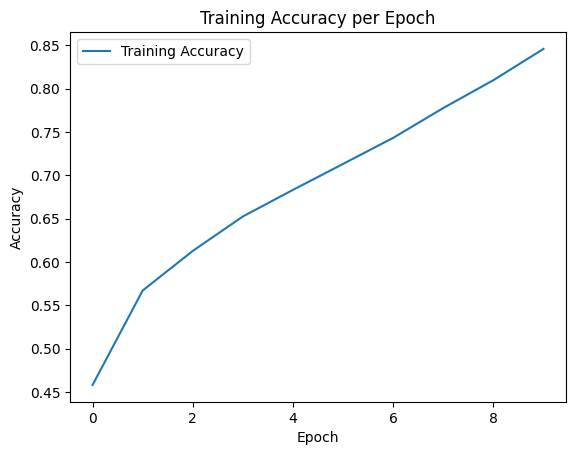

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_accuracies, label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy per Epoch')
plt.legend()
plt.show()

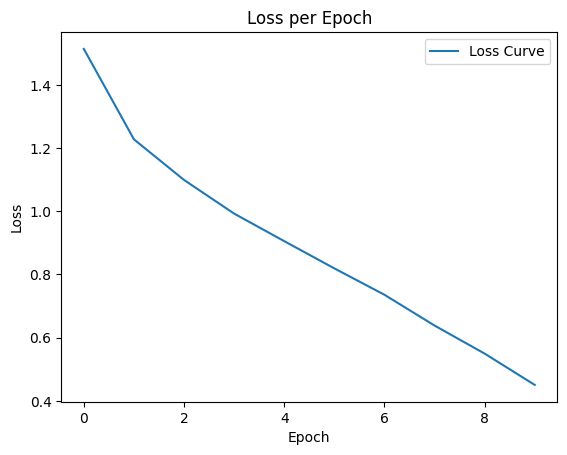

In [ ]:
plt.plot(train_losses, label='Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

### 1.5 Model Evaluation

In [ ]:
with torch.set_grad_enabled(False):
  print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader, device=DEVICE)))

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test accuracy: 68.01%


### 1.6 Data agumentation

In [ ]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

### 1.7 Transforming CIFAR-10 dataset

In [ ]:
### CIFAR-10 Dataset ###

transformed_train_dataset = datasets.CIFAR10(root='data',
                                 train=True,
                                 transform=train_transform,
                                 download=True)
transformed_test_dataset = datasets.CIFAR10(root='data',
                                train=False,
                                transform=transform)

transformed_train_loader = DataLoader(dataset=transformed_train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=8,
                          shuffle=True)

transformed_test_loader = DataLoader(dataset=transformed_test_dataset,
                         batch_size=BATCH_SIZE,
                         num_workers=8,
                         shuffle=False)

# Checking the dataset

for images, labels in transformed_train_loader:
  print(f"Image batch demensions: {images.shape}")
  print(f"Image label demensions: {labels.shape}")
  break

for images, labels in transformed_test_loader:
  print(f"Image batch demensions: {images.shape}")
  print(f"Image label demensions: {labels.shape}")
  break

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Image batch demensions: torch.Size([128, 3, 32, 32])
Image label demensions: torch.Size([128])
Image batch demensions: torch.Size([128, 3, 32, 32])
Image label demensions: torch.Size([128])


### 1.8 Train model after agumentation and transfromation

In [ ]:
model_with_transformed_data = LeNet5(NUM_CLASSES, GRAYSCALE)
model_with_transformed_data.to(DEVICE)

optimizer = torch.optim.Adam(model_with_transformed_data.parameters(), lr=LEARNING_RATE)

In [ ]:
train_losses_with_agumented_data = []
train_accuracies_with_agumented_data = []

def compute_accuracy(model, data_loader, device):
  correct_pred, num_examples = 0, 0
  for batch_idx, (features, targets) in enumerate(data_loader):

    features = features.to(device)
    targets = targets.to(device)

    logits, probas = model(features)
    _, predicted_labels = torch.max(probas, 1)
    num_examples += targets.size(0)
    correct_pred += (predicted_labels == targets).sum()

  return correct_pred.float()/num_examples*100

start_time = time.time()
for epoch in range(NUM_EPOCHS):
  model_with_transformed_data.train()

  running_loss = 0
  correct = 0
  total = 0

  for batch_idx, (features, targets) in enumerate(transformed_train_loader):

    features = features.to(DEVICE)
    targets = targets.to(DEVICE)

    ### Forward and Back propagation
    logits, probs = model_with_transformed_data(features)
    loss = F.cross_entropy(logits, targets)
    optimizer.zero_grad()

    loss.backward()

    ### Update params
    optimizer.step()

    ## Total loss of each epoch
    running_loss += loss.item()

    # Accuracy
    _, predicted = torch.max(probs, 1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

    ### Logging
    if batch_idx % 50 == 0:
      print ('Epoch: %03d/%03d | Batch %04d/%04d | Loss: %.4f'
                  %(epoch+1, NUM_EPOCHS, batch_idx,
                    len(transformed_train_loader), loss))

  avg_loss = running_loss/len(train_loader)
  accuracy = correct/total

  train_losses_with_agumented_data.append(avg_loss)
  train_accuracies_with_agumented_data.append(accuracy)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch: 001/010 | Batch 0000/0391 | Loss: 2.3019
Epoch: 001/010 | Batch 0050/0391 | Loss: 1.7736
Epoch: 001/010 | Batch 0100/0391 | Loss: 1.6682
Epoch: 001/010 | Batch 0150/0391 | Loss: 1.5956
Epoch: 001/010 | Batch 0200/0391 | Loss: 1.4460
Epoch: 001/010 | Batch 0250/0391 | Loss: 1.3972
Epoch: 001/010 | Batch 0300/0391 | Loss: 1.3503
Epoch: 001/010 | Batch 0350/0391 | Loss: 1.5673
Epoch: 002/010 | Batch 0000/0391 | Loss: 1.2086
Epoch: 002/010 | Batch 0050/0391 | Loss: 1.4829
Epoch: 002/010 | Batch 0100/0391 | Loss: 1.3922
Epoch: 002/010 | Batch 0150/0391 | Loss: 1.3040
Epoch: 002/010 | Batch 0200/0391 | Loss: 1.3676
Epoch: 002/010 | Batch 0250/0391 | Loss: 1.1458
Epoch: 002/010 | Batch 0300/0391 | Loss: 1.2470
Epoch: 002/010 | Batch 0350/0391 | Loss: 1.1336
Epoch: 003/010 | Batch 0000/0391 | Loss: 1.2566
Epoch: 003/010 | Batch 0050/0391 | Loss: 1.3712
Epoch: 003/010 | Batch 0100/0391 | Loss: 1.2243
Epoch: 003/010 | Batch 0150/0391 | Loss: 1.2538
Epoch: 003/010 | Batch 0200/0391 | Loss:

### 1.9 Model Evaluation after image Transfromation and Agumentation

In [ ]:
with torch.set_grad_enabled(False):
  print('Test accuracy: %.2f%%' % (compute_accuracy(model_with_transformed_data, transformed_test_loader, device=DEVICE)))

Test accuracy: 70.11%


#### 1.9.1 Plotting loss curve and accuracy curve after data agumentation

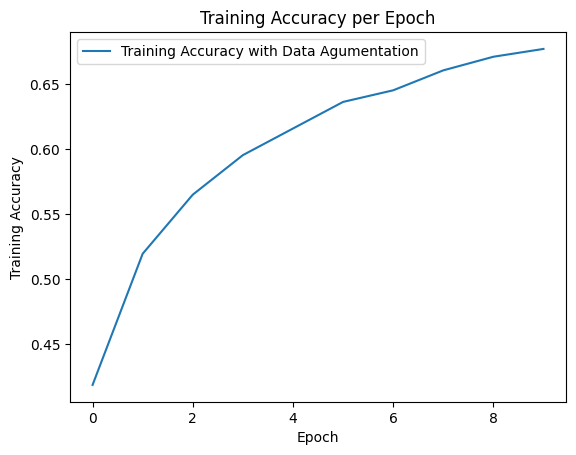

In [ ]:
plt.plot(train_accuracies_with_agumented_data, label='Training Accuracy with Data Agumentation')
plt.xlabel('Epoch')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy per Epoch')
plt.legend()
plt.show()

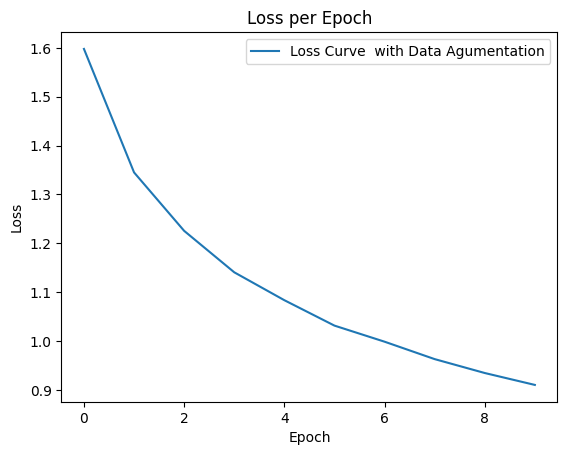

In [ ]:
plt.plot(train_losses_with_agumented_data, label='Loss Curve  with Data Agumentation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.show()

In [13]:
!git clone https://github.com/tayfunai/CNN-IMAGE-CLASSIFICATION-MODELS.git

Cloning into 'CNN-IMAGE-CLASSIFICATION-MODELS'...
remote: Enumerating objects: 22, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 22 (delta 3), reused 6 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (22/22), 358.43 KiB | 7.47 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [12]:
%cd /content

/content


In [16]:
!cp '/content/drive/MyDrive/Colab Notebooks/LeNet-5_CIFAR-10_Classifier.ipynb' '/content/CNN-IMAGE-CLASSIFICATION-MODELS/CNN-IMAGE-CLASSIFICATION-MODELS/LeNet-5_CIFAR-10_Classifier.ipynb'

cp: cannot create regular file '/content/CNN-IMAGE-CLASSIFICATION-MODELS/CNN-IMAGE-CLASSIFICATION-MODELS/LeNet-5_CIFAR-10_Classifier.ipynb': No such file or directory


In [14]:
%cd /content/CNN-IMAGE-CLASSIFICATION-MODELS

/content/CNN-IMAGE-CLASSIFICATION-MODELS
